# **Generate Dataset**
This code generates a dataset with n families and m waveform images in each family with the function: gen_uniform_based_waveforms(n, m, genFamiliesOnSinglePlot=False). The dataset has a very specific format so that it can be used with our clustering and error detection code.  
*   Images have names with labels in the the format: (5-digit familycode)(good/bad waveform)(date).png ex. **YYJ96H**good**0220025820.805883**.png  
*   Images are stored in a folder called "images".
*   This was created using Google Colab so by default the folder is found in the directory "content".
*   The full path of an example image is content/images/OCREJ5good0220025717.761071.png
*   All images are of size (1000, 1400) and have a white background 
*   [15:21] of the full image path contains the 5-digit family code and [21:24] contains the first 3 letters of the error label (goo/bad)


In [2]:
# imports
import csv
import math
import os
from datetime import datetime
import random 

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from numpy.core.function_base import linspace
from tqdm import tqdm
import string

In [3]:
titleHeaders = ['Simulate', 'Validate', 'ATE']
xAxisLabels = ['Frequency', 'Voltage', 'Time', 'Decibels (dB)', 'Degrees']
yAxisLabels = ['S_PA_Out_PA_In_Phase (deg)',
'S_PA_Out_PA_In_Mag (dB)',
'S_PA_In_PA_Out_Mag (dB)',
'S_PA_Out_PA_Out_Phase (deg)',
'S_PA_Out_PA_Out_Mag (dB)',
'S_PA_In_PA_In_Phase (deg)',
'S_PA_In_PA_In_Mag (dB)',
'S_PA_In_PA_Out_Phase (deg)',
'Mu2 source',
'K Factor',
'Mu1 load',
'Gain Imbalance (dB)',
'Common-mode rejection ratio (dB)',
'Phase Imbalance (deg)',
'Idc_Vcc1 (mA)',
'Idc_Vcc2 (mA)',
'Gain (dB)',
'Pout (dBm)',
'Irf_Vcc1 (mA)',
'Irf_Vcc2 (mA)',
'OP1dB (dBm)',
'IP1dB (dBm)',
'IP3dB (dBm)',
'OP3dB (dBm)',
'OIP3 Min (dBm)',
'Noise Floor Power (dBm)',
'OIP3 AVG (dBm)',
'OIP3 Delta (dB)',
'OIP3 LSB (dBm)',
'OIP3 Max (dBm)',
'IIP3 Min (dBm)',
'OIP3 USB (dBm)',
'IIP3 USB (dBm)',
'Actual_Pin_at_f2 (dBm)',
'Actual_Pin_at_f1 (dBm)',
'Pout_at_IMH (dBm)',
'Noise Floor Frequency (GHz)',
'Attenuation (dB)',
'Pout_at_IML (dBm)',
'IIP3 Delta (dB)',
'Gain_at_f1 (dB)',
'Pout_at_f2 (dBm)',
'IMH Frequency (GHz)',
'IML Frequency (GHz)',
'Gain_at_f2 (dB)',
'IIP3 Max (dBm)',
'IIP3 LSB (dBm)',
'Pout_at_f1 (dBm)',
'IIP3 AVG (dBm)',
'Gain Flatness (dB)',
'Group Delay (ps)',
'Noise Figure (dB)',
'Noise Temperature (K)',
'Noise Gain (dB)',
'Idc_Vdig (mA)',
'Irf_Vcc (mA)',
'ACLR Adj. Channel Max (dBc)',
'ACLR Alt1. Channel Max (dBc)',
'ACLR Up. Alt1. Channel (dBc)',
'ACLR Up. Adj. Channel (dBc)',
'ACLR Low. Alt1. Channel (dBc)',
'ACLR Low. Adj. Channel (dBc)',
'Idc_Vcc (mA)',
'Vth1 (V)',
'Toff (ns)',
'Ton (ns)',
'Idc_Vcc2 (uA)',
'Idc_Vcc1 (uA)',
'Idc_Vcc (uA)',
'Vth2 (V)']

In [4]:
IMAGE_DIRECTORY = 'images'

def save_plot( xTitle, yTitle, plot_family):
    title = f'{get_random_element_from_array(titleHeaders)} {yTitle}'
    current_time = datetime.now().strftime("%m%d%H%M%S.%f")
    filename = f'{IMAGE_DIRECTORY}/{plot_family}{str(current_time)}.png'
    plt.title(title)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.savefig(filename)
    plt.cla()
    return filename

def save_plots(x, waveforms, genFamiliesOnSinglePlot, errorIndexes):
    os.makedirs(IMAGE_DIRECTORY,exist_ok=True)
    xTitle = get_random_element_from_array(xAxisLabels)
    yTitle = get_random_element_from_array(yAxisLabels)

    # create random name for the family of plots
    plot_family = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))
    
    if genFamiliesOnSinglePlot:
      for y in waveforms:
          plt.plot(x, y, color=random_color(), linewidth=5)
      save_plot(xTitle, yTitle)
    else:
      #with open(f'{IMAGE_DIRECTORY}/lables.csv', 'a', newline='') as csvfile:
          #writer = csv.writer(csvfile, delimiter=',')
      for n in range(len(waveforms)):
          ylim = get_max_y_axis_plot_scale(x, waveforms)
          plt.plot(x, waveforms[n], color=random_color())
          plt.gca().set_ylim(ylim)
          label = 'good'
          if n in errorIndexes:
              label='bad'
          filename = save_plot(xTitle, yTitle, plot_family+label)
              #writer.writerow([os.path.basename(filename), label, plot_family])
              

def get_max_y_axis_plot_scale(x, waveforms):
    for w in waveforms:
        plt.plot(x, w)
    limits = plt.gca().get_ylim()
    plt.cla()
    return limits

def gen_random_square_wave():
    return rnd.normal(0,1)

def add_noise(waveforms):
    scale = (np.max(waveforms) - np.min(waveforms)) * np.abs(rnd.normal(0,.005))
    withNoise = []
    for w in waveforms:
        noise = np.random.normal(0, scale, w.shape)
        withNoise.append(w+noise)
    return withNoise

def random_color():
    return (rnd.random(), rnd.random(), rnd.random())

def gen_random_uniform_based_waveform(x, segments):
    y = (x - rnd.uniform(-1, 1))
    for s in range(segments):
        y = y * (x - rnd.uniform(-1, 1))
    return y

def get_random_element_from_array(names):
    return names[rnd.randint(0,len(names))]

def get_error_range(y):
    bounds = rnd.rand(2)
    maxErrorLength = len(y) / 2
    return math.floor(np.min(bounds) * maxErrorLength), math.ceil(np.max(bounds) * maxErrorLength)

def get_random_value_in_y_range_with_factor(y):
    errorScale = rnd.uniform(-1,1)
    percentRangeForError = 1.5
    return (np.max(y) - np.min(y)) * errorScale * percentRangeForError

def introduce_narrow_spike(y):
    y_error = y
    min, max = np.min(y), np.max(y)
    spike_height = np.abs(max-min) * rnd.random()
    errorPoint = rnd.randint(0,len(y))
    y_error[errorPoint] = y_error[errorPoint] + spike_height
    return y_error, y_error[errorPoint]

def introduce_step(y):
    y_error = y
    errorPointMin, errorPointMax = get_error_range(y)
    delta = get_random_value_in_y_range_with_factor(y)
    y[errorPointMin:errorPointMax] = y[errorPointMin : errorPointMax] + delta
    return y_error, y[errorPointMin:errorPointMax] 

def inroduce_constant_error(y):
    y_error = y
    min, max = get_error_range(y)
    error_value = get_random_value_in_y_range_with_factor(y)
    y[min:max] = error_value
    return y_error, y[min:max]

def introduce_error(y):
    errorType = rnd.randint(0,3)
    if errorType == 0:
        return introduce_narrow_spike(y)
    elif errorType == 1:
        return introduce_step(y)
    elif errorType ==2:
        return inroduce_constant_error(y)
    return y

def gen_uniform_based_waveforms(numFamilies, waveformsPerFamily, genFamiliesOnSinglePlot):
    print(f'Total: {numFamilies*waveformsPerFamily}. Creating {numFamilies} waveform families with {waveformsPerFamily} waveforms per family.')
    plt.figure(figsize=(7,5), dpi=200)
    for f in range(numFamilies):
        factorOfWaveformsWithError = 1.3
        numberWithErrors = math.floor(waveformsPerFamily * factorOfWaveformsWithError * rnd.random())
        errorIndexes = rnd.randint(0, waveformsPerFamily-1,numberWithErrors)
        segments = rnd.randint(4,8)
        xBounds = rnd.rand(2)
        xMin,xMax = np.min(xBounds), np.max(xBounds)
        xPointCount = 1000
        x = np.linspace(xMin, xMax, num=xPointCount)
        y = gen_random_uniform_based_waveform(x, segments)
        waveforms = []
        waveforms_errors = []
        for n in tqdm(range(waveformsPerFamily), desc=f'Generating Waveforms for family {f}'):
            lineBounds = rnd.random(2)
            line = np.linspace(lineBounds.min(), lineBounds.max(), num=xPointCount)
            ys = y * line
            error_ys = 0
            if n in errorIndexes:
                ys, error_ys = introduce_error(ys)
            waveforms.append(ys)
            waveforms_errors.append(error_ys)
        waveforms = add_noise(waveforms)
        save_plots(x, waveforms, genFamiliesOnSinglePlot, errorIndexes)

Total: 300. Creating 15 waveform families with 20 waveforms per family.


Generating Waveforms for family 14: 100%|██████████| 20/20 [00:00<00:00, 5623.15it/s]


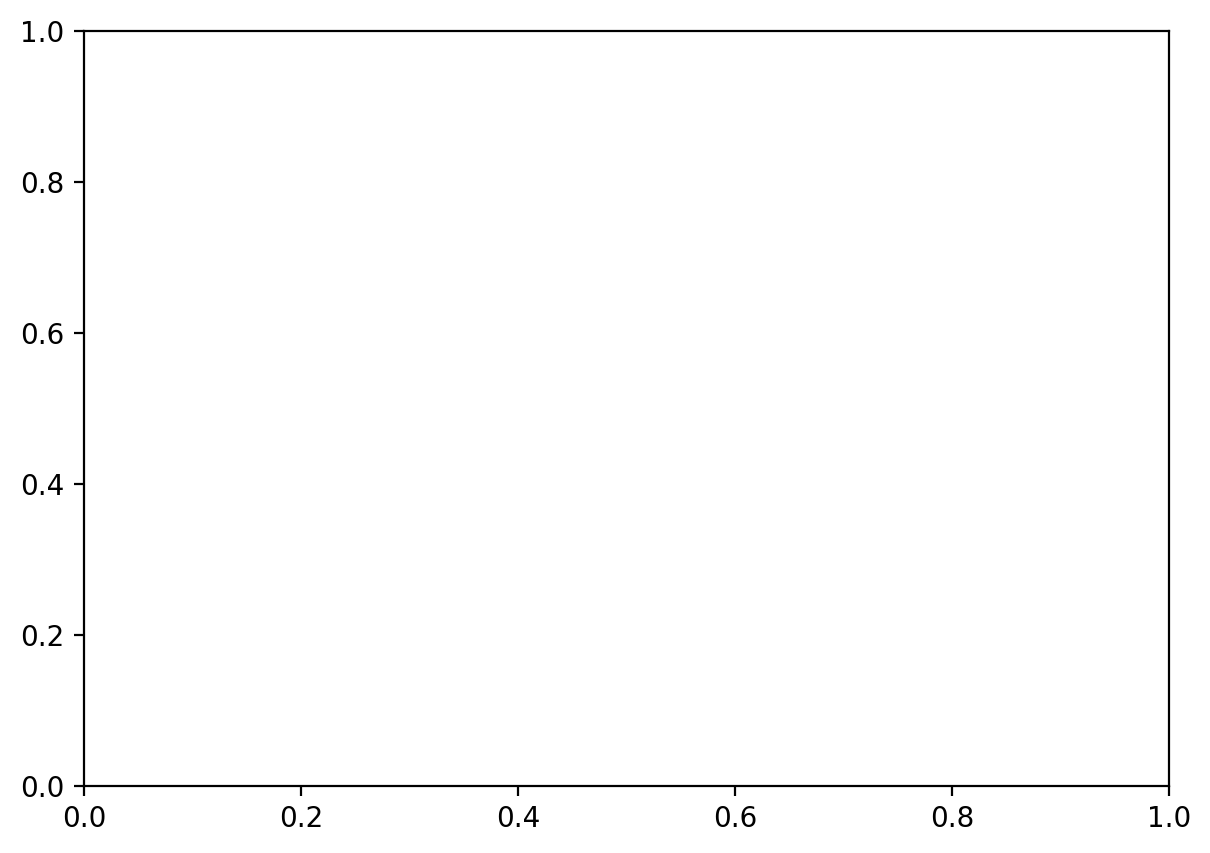

In [5]:
 gen_uniform_based_waveforms(15, 20, genFamiliesOnSinglePlot=False)

In [8]:
# save the dataset
!zip -r /content/images_april06_small.zip /content/images

from google.colab import files
files.download("/content/images_april06_small.zip")

  adding: content/images/ (stored 0%)
  adding: content/images/GIT5VCgood0406223954.663526.png (deflated 14%)
  adding: content/images/G5ZKGObad0406223926.571853.png (deflated 14%)
  adding: content/images/CW19XNbad0406224040.833224.png (deflated 16%)
  adding: content/images/AB9OB4good0406224047.970547.png (deflated 16%)
  adding: content/images/G5ZKGOgood0406223927.262161.png (deflated 12%)
  adding: content/images/9296NHbad0406224007.824461.png (deflated 14%)
  adding: content/images/0YIUDXbad0406223916.938233.png (deflated 15%)
  adding: content/images/G5ZKGOgood0406223924.322589.png (deflated 14%)
  adding: content/images/9YRH7Mbad0406223938.114029.png (deflated 15%)
  adding: content/images/E8A7EYgood0406224003.508453.png (deflated 17%)
  adding: content/images/041Q5Qbad0406224022.186680.png (deflated 10%)
  adding: content/images/NCKI67good0406223935.831346.png (deflated 13%)
  adding: content/images/NCKI67good0406223935.448465.png (deflated 13%)
  adding: content/images/HFERPNg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>